In [1]:
# Python imports, put at the top for simplicity
from mdp_dp_rl.algorithms.dp.dp_analytic import DPAnalytic
from stochastic_service_composition.declare_utils import *
from docs.notebooks.utils import render_service, render_target, render_composition_mdp,\
    print_policy_data, print_value_function, print_q_value_function
from stochastic_service_composition.composition_mdp import composition_mdp
from stochastic_service_composition.services import build_service_from_transitions, Service
from stochastic_service_composition.target import build_target_from_transitions

## Use case for "Stochastic Service Composition with Industrial APIs" - Chip Production.

In this notebook, we present the implementation of the use case for "Stochastic Service Composition with Industrial APIs" about chip production.

# Available Services

In the following we provide definitions about available services:

In [69]:
LOW_PROB = 0.05

# probabilities of being broken after an action
DEFAULT_BROKEN_PROB = LOW_PROB
BROKEN_PROB = 0.5
HIGH_BROKEN_PROB = 0.7

# default probability of being unemployable after the configuration
DEFAULT_UNEMPLOYABLE_PROB = LOW_PROB
HIGH_UNEMPLOYABLE_PROB = 0.5

# costs of the machines that perform their job in different countries
DEFAULT_USA_REWARD = -1.0
WAR_REWARD = -3.0
USA_REWARD = -2.0
HIGH_USA_REWARD = -5.0
UK_REWARD = -6.8
CHINA_REWARD = -11.7
TAIWAN_REWARD = -12.2
RUSSIA_REWARD = -9.12 # we have to take into the account political problems
NORWAY_REWARD = -7.16
BRAZIL_REWARD = -6.7
FRANCE_REWARD = -7.6
MALAYSIA_REWARD = -14.73
TURKEY_REWARD = -10.16
KAZAKHSTAN_REWARD = -10.4
CHILE_REWARD = -7.8
BOLIVIA_REWARD = -6.8
ARGENTINA_REWARD = -8.55
MOROCCO_REWARD = -7.9
JAPAN_REWARD = -10.1
SOUTH_KOREA = -10.7
NETHERLANDS_REWARD = -7.5
#ISRAEL_REWARD = -10.81 # we have to take into the account political/religious problems

# default reward when the service becomes broken
DEFAULT_BROKEN_REWARD = -10.0

In [70]:
# all the atomic actions for the task
PICK_BUY_DESIGN = "pick_buy_design"
PICK_SILICON = "pick_silicon"
PICK_WAFER = "pick_wafer"
PICK_BORON = "pick_boron"
PICK_PHOSPHOR = "pick_phosphor"
CLEANING = "cleaning"
FILM_DEPOSITION = "film_deposition"
RESIST_COATING = "resist_coating"
EXPOSURE = "exposure"
DEVELOPMENT = "development"
ETCHING = "etching"
IMPURITIES_IMPLANTATION = "impurities_implantation"
ACTIVATION = "activation"
RESIST_STRIPPING = "resist_stripping"
ASSEMBLY = "assembly"
TESTING = "testing"
PACKAGING = "packaging"

In [71]:
# service names
DESIGN_SERVICE_NAME_USA = "design_usa"                                      # human
DESIGN_SERVICE_NAME_UK = "design_uk"                                        # human
DESIGN_SERVICE_NAME_CHINA = "design_china"                                  # human
DESIGN_SERVICE_NAME_TAIWAN = "design_taiwan"                                # human
SILICON_WAREHOUSE_SERVICE_NAME = "silicon_warehouse"                        # warehouse
WAFER_WAREHOUSE_SERVICE_NAME = "wafer_warehouse"                            # warehouse
BORON_WAREHOUSE_SERVICE_NAME = "boron_warehouse"                            # warehouse
PHOSPHOR_WAREHOUSE_SERVICE_NAME = "phosphor_warehouse"                      # warehouse
SILICON_SERVICE_NAME_CHINA = "silicon_china"                                # human
SILICON_SERVICE_NAME_RUSSIA = "silicon_russia"                              # human
SILICON_SERVICE_NAME_NORWAY = "silicon_norway"                              # human
SILICON_SERVICE_NAME_USA = "silicon_usa"                                    # human
SILICON_SERVICE_NAME_FRANCE = "silicon_france"                              # human
SILICON_SERVICE_NAME_BRAZIL = "silicon_brazil"                              # human
SILICON_SERVICE_NAME_MALAYSIA = "silicon_malaysia"                          # human
WAFER_SERVICE_NAME_JAPAN = "wafer_japan"                                    # human
WAFER_SERVICE_NAME_SOUTH_KOREA = "wafer_south_korea"                        # human
BORON_SERVICE_NAME_TURKEY = "boron_turkey"                                  # human
BORON_SERVICE_NAME_USA = "boron_usa"                                        # human
BORON_SERVICE_NAME_KAZAKHSTAN = "boron_kazakhstan"                          # human
BORON_SERVICE_NAME_CHILE = "boron_chile"                                    # human
BORON_SERVICE_NAME_CHINA = "boron_china"                                    # human
BORON_SERVICE_NAME_ARGENTINA = "boron_argentina"                            # human
BORON_SERVICE_NAME_RUSSIA = "boron_russia"                                  # human
BORON_SERVICE_NAME_BOLIVIA = "boron_bolivia"                                # human
PHOSPHOR_SERVICE_NAME_MOROCCO = "phosphor_morocco"                          # human
PHOSPHOR_SERVICE_NAME_CHINA = "phosphor_china"                              # human
PHOSPHOR_SERVICE_NAME_USA = "phosphor_usa"                                  # human
CLEANING_HUMAN_SERVICE_NAME = "cleaning_human"                              # human
CLEANING_SERVICE_NAME = "cleaning_machine"                                  # machine
FILM_DEPOSITION1_SERVICE_NAME = "film_deposition_machine1"                  # machine
FILM_DEPOSITION2_SERVICE_NAME = "film_deposition_machine2"                  # machine
RESIST_COATING1_SERVICE_NAME = "resist_coating_machine1"                    # machine
RESIST_COATING2_SERVICE_NAME = "resist_coating_machine2"                    # machine
EXPOSURE_HUMAN_SERVICE_NAME = "exposure_human"                              # human
EXPOSURE_SERVICE_NAME = "exposure_machine"                                  # machine
DEVELOPMENT1_SERVICE_NAME = "development1_machine"                          # machine
DEVELOPMENT2_SERVICE_NAME = "development2_machine"                          # machine
ETCHING1_SERVICE_NAME = "etching1_machine"                                  # machine
ETCHING2_SERVICE_NAME = "etching2_machine"                                  # machine
IMPURITIES_IMPLANTATION1_SERVICE_NAME = "impurities_implantation1_machine"  # machine
IMPURITIES_IMPLANTATION2_SERVICE_NAME = "impurities_implantation2_machine"  # machine
ACTIVATION_HUMAN_SERVICE_NAME = "activation_human"                          # human
ACTIVATION_SERVICE_NAME = "activation_machine"                              # machine
RESIST_STRIPPING1_SERVICE_NAME = "resist_stripping1_machine"                # machine
RESIST_STRIPPING2_SERVICE_NAME = "resist_stripping2_machine"                # machine
ASSEMBLY_HUMAN_SERVICE_NAME = "assembly_human"                              # human
ASSEMBLY_SERVICE_NAME = "assembly_machine"                                  # machine
TESTING_HUMAN_SERVICE_NAME = "testing_human"                                # human
TESTING_SERVICE_NAME = "testing_machine"                                    # machine
PACKAGING_HUMAN_SERVICE_NAME = "packaging_human"                            # human
PACKAGING_SERVICE_NAME = "packaging_machine"                                # human

We have different type of services:

- generic breakable machines;
- complex breakable machines;
- warehouse machines;
- human workers

In [72]:
def build_generic_breakable_service(service_name: str, action_name: str, broken_prob: float, broken_reward: float, action_reward: float):
    assert 0.0 <= broken_prob <= 1.0
    deterministic_prob = 1.0
    success_prob = deterministic_prob - broken_prob
    transitions = {
        "available": {
          action_name: ({"done": success_prob, "broken": broken_prob}, action_reward),
        },
        "broken": {
            f"check_{action_name}": ({"available": 1.0}, broken_reward),
        },
        "done": {
            f"check_{action_name}": ({"available": 1.0}, 0.0),
        }
    }
    final_states = {"available"}
    initial_state = "available"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

def build_complex_breakable_service(service_name: str, action_name: str, broken_prob: float, unemployable_prob: float, broken_reward: float, action_reward: float) -> Service:
    assert 0.0 <= broken_prob <= 1.0
    deterministic_prob = 1.0
    configure_success_prob = deterministic_prob - unemployable_prob
    op_success_prob = deterministic_prob - broken_prob
    transitions = {
        "ready": { # current state
            f"CONFIG[{action_name}]": # action
                (
                    {
                        "configured": deterministic_prob # next state : prob
                    },
                    0.0
                ),
        },
        "configured": {
            f"CHECKED[{action_name}]":
                (
                    {
                    "executing": configure_success_prob,
                    "broken": unemployable_prob
                    } if unemployable_prob > 0.0 else {"executing": configure_success_prob},
                    0.0
                ),
        },
        "executing": {
            action_name: # operation
                (
                    {
                        "ready": op_success_prob,
                        "broken": broken_prob
                    } if broken_prob > 0.0 else {"ready": op_success_prob},
                    action_reward
                ),
        },
        "broken": {
            f"RESTORE[{action_name}]":
               (
                   {
                       "repairing": deterministic_prob
                   },
                   broken_reward
               ),
        },
        "repairing": {
            f"REPAIRED[{action_name}]":
                (
                    {
                        "ready": deterministic_prob
                    },
                    0.0
                ),
        },

    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

def build_generic_service_one_state(
    service_name: str,
    operation_names: Set[str],
    action_reward: float,
) -> Service:
    """Build the one state device."""
    transitions = {
        "ready": {
            operation_name: ({"ready": 1.0}, action_reward) for operation_name in operation_names
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

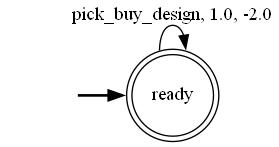

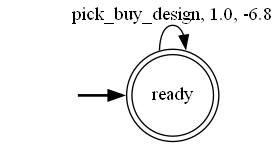

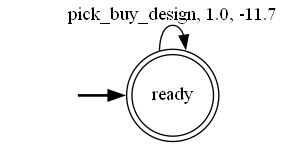

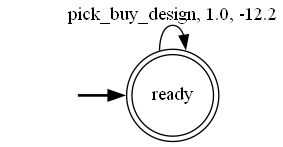

In [73]:
def design_service(name: str, action_reward: float) -> Service:
    """Build the design device."""
    return build_generic_service_one_state(
        name,
        {PICK_BUY_DESIGN},
        action_reward=action_reward
    )

service_design_usa = design_service(DESIGN_SERVICE_NAME_USA, USA_REWARD)
service_design_uk = design_service(DESIGN_SERVICE_NAME_UK, UK_REWARD)
service_design_china = design_service(DESIGN_SERVICE_NAME_CHINA, CHINA_REWARD)
service_design_taiwan = design_service(DESIGN_SERVICE_NAME_TAIWAN, TAIWAN_REWARD)
render_service(service_design_usa)
render_service(service_design_uk)
render_service(service_design_china)
render_service(service_design_taiwan)

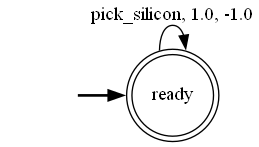

In [74]:
def silicon_warehouse_service(name: str = SILICON_WAREHOUSE_SERVICE_NAME, action_reward: float = DEFAULT_USA_REWARD) -> Service:
    """Build the silicon warehouse device."""
    return build_generic_service_one_state(
        name,
        {PICK_SILICON},
        action_reward=action_reward
    )

service_silicon_warehouse = silicon_warehouse_service()
render_service(service_silicon_warehouse)

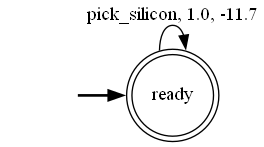

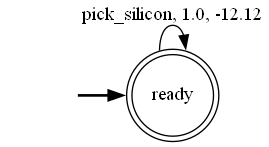

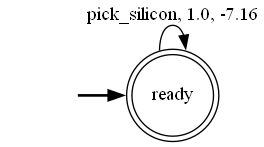

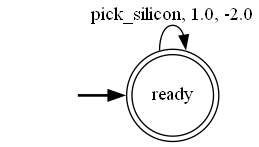

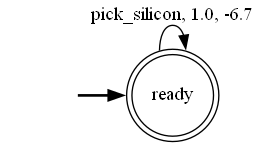

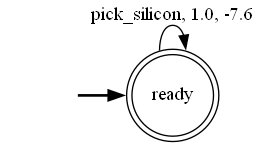

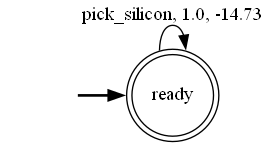

In [75]:
def silicon_service(name: str, action_reward) -> Service:
    """Build the silicon device."""
    return build_generic_service_one_state(
        name,
        {PICK_SILICON},
        action_reward=action_reward
    )

service_silicon_china = silicon_service(SILICON_SERVICE_NAME_CHINA, CHINA_REWARD)
service_silicon_russia = silicon_service(SILICON_SERVICE_NAME_RUSSIA, RUSSIA_REWARD + WAR_REWARD)
service_silicon_norway = silicon_service(SILICON_SERVICE_NAME_NORWAY, NORWAY_REWARD)
service_silicon_usa = silicon_service(SILICON_SERVICE_NAME_USA, USA_REWARD)
service_silicon_brazil = silicon_service(SILICON_SERVICE_NAME_BRAZIL, BRAZIL_REWARD)
service_silicon_france = silicon_service(SILICON_SERVICE_NAME_FRANCE, FRANCE_REWARD)
service_silicon_malaysia = silicon_service(SILICON_SERVICE_NAME_MALAYSIA, MALAYSIA_REWARD)
render_service(service_silicon_china)
render_service(service_silicon_russia)
render_service(service_silicon_norway)
render_service(service_silicon_usa)
render_service(service_silicon_brazil)
render_service(service_silicon_france)
render_service(service_silicon_malaysia)

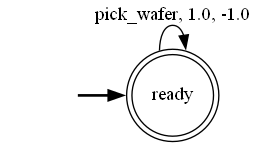

In [76]:
def wafer_warehouse_service(name: str = WAFER_WAREHOUSE_SERVICE_NAME, action_reward: float = DEFAULT_USA_REWARD) -> Service:
    """Build the wafer warehouse device."""
    return build_generic_service_one_state(
        name,
        {PICK_WAFER},
        action_reward=action_reward
    )

service_wafer_warehouse = wafer_warehouse_service()
render_service(service_wafer_warehouse)

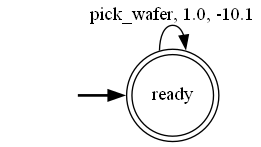

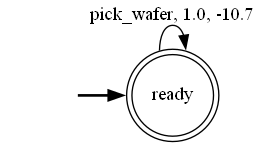

In [77]:
def wafer_service(name: str, action_reward: float) -> Service:
    """Build the wafer device."""
    return build_generic_service_one_state(
        name,
        {PICK_WAFER},
        action_reward=action_reward
    )

service_wafer_japan = wafer_service(WAFER_SERVICE_NAME_JAPAN, JAPAN_REWARD)
service_wafer_south_korea = wafer_service(WAFER_SERVICE_NAME_SOUTH_KOREA, SOUTH_KOREA)
render_service(service_wafer_japan)
render_service(service_wafer_south_korea)

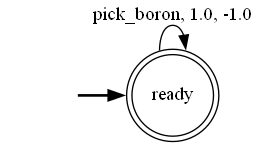

In [78]:
def boron_warehouse_service(name: str = BORON_WAREHOUSE_SERVICE_NAME, action_reward: float = DEFAULT_USA_REWARD) -> Service:
    """Build the boron warehouse device."""
    return build_generic_service_one_state(
        name,
        {PICK_BORON},
        action_reward=action_reward
    )

service_boron_warehouse = boron_warehouse_service()
render_service(service_boron_warehouse)

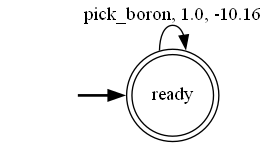

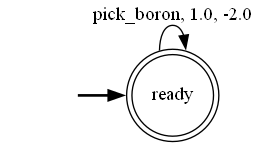

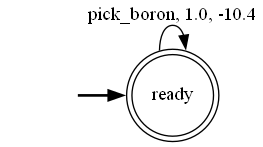

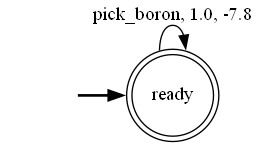

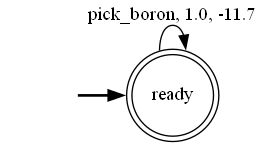

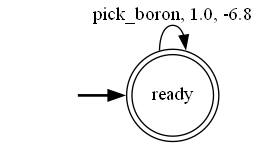

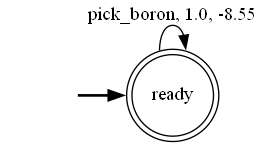

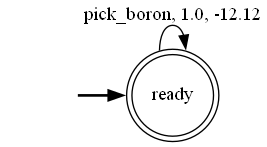

In [79]:
def boron_service(name: str, action_reward: float) -> Service:
    """Build the boron device."""
    return build_generic_service_one_state(
        name,
        {PICK_BORON},
        action_reward=action_reward
    )

service_boron_turkey = boron_service(BORON_SERVICE_NAME_TURKEY, TURKEY_REWARD)
service_boron_usa = boron_service(BORON_SERVICE_NAME_USA, USA_REWARD)
service_boron_kazakhstan = boron_service(BORON_SERVICE_NAME_KAZAKHSTAN, KAZAKHSTAN_REWARD)
service_boron_chile = boron_service(BORON_SERVICE_NAME_CHILE, CHILE_REWARD)
service_boron_china = boron_service(BORON_SERVICE_NAME_CHINA, CHINA_REWARD)
service_boron_bolivia = boron_service(BORON_SERVICE_NAME_BOLIVIA, BOLIVIA_REWARD)
service_boron_argentina = boron_service(BORON_SERVICE_NAME_ARGENTINA, ARGENTINA_REWARD)
service_boron_russia = boron_service(BORON_SERVICE_NAME_RUSSIA, RUSSIA_REWARD + WAR_REWARD)
render_service(service_boron_turkey)
render_service(service_boron_usa)
render_service(service_boron_kazakhstan)
render_service(service_boron_chile)
render_service(service_boron_china)
render_service(service_boron_bolivia)
render_service(service_boron_argentina)
render_service(service_boron_russia)

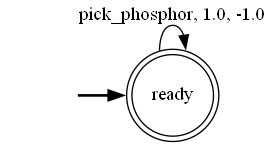

In [80]:
def phosphor_warehouse_service(name: str = PHOSPHOR_WAREHOUSE_SERVICE_NAME, action_reward: float = DEFAULT_USA_REWARD) -> Service:
    """Build the phosphor warehouse device."""
    return build_generic_service_one_state(
        name,
        {PICK_PHOSPHOR},
        action_reward=action_reward
    )

service_phosphor_warehouse = phosphor_warehouse_service()
render_service(service_phosphor_warehouse)

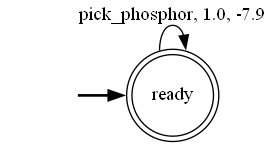

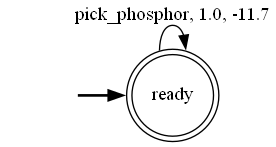

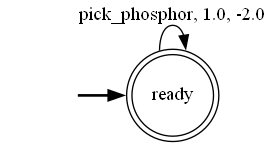

In [81]:
def phosphor_service(name: str, action_reward: float) -> Service:
    """Build the phosphor device."""
    return build_generic_service_one_state(
        name,
        {PICK_PHOSPHOR},
        action_reward=action_reward
    )

service_phosphor_morocco = phosphor_service(PHOSPHOR_SERVICE_NAME_MOROCCO, MOROCCO_REWARD)
service_phosphor_china = phosphor_service(PHOSPHOR_SERVICE_NAME_CHINA, CHINA_REWARD)
service_phosphor_usa = phosphor_service(PHOSPHOR_SERVICE_NAME_USA, USA_REWARD)
render_service(service_phosphor_morocco)
render_service(service_phosphor_china)
render_service(service_phosphor_usa)

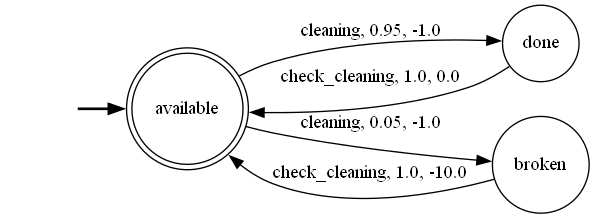

In [82]:
def cleaning_service(name: str = CLEANING_SERVICE_NAME, broken_prob: float = DEFAULT_BROKEN_PROB, broken_reward: float = DEFAULT_BROKEN_REWARD, action_reward: float = DEFAULT_USA_REWARD) -> Service:
    """Build the cleaning device."""
    return build_generic_breakable_service(name, CLEANING, broken_prob=broken_prob, broken_reward=broken_reward, action_reward=action_reward)
service_cleaning=cleaning_service()
render_service(service_cleaning)

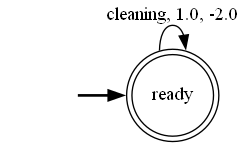

In [83]:
def cleaning_human_service(name: str = CLEANING_HUMAN_SERVICE_NAME, action_reward: float = USA_REWARD) -> Service:
    """Build the human cleaning device."""
    return build_generic_service_one_state(
        name,
        {CLEANING},
        action_reward=action_reward
    )

service_cleaning_human = cleaning_human_service()
render_service(service_cleaning_human)

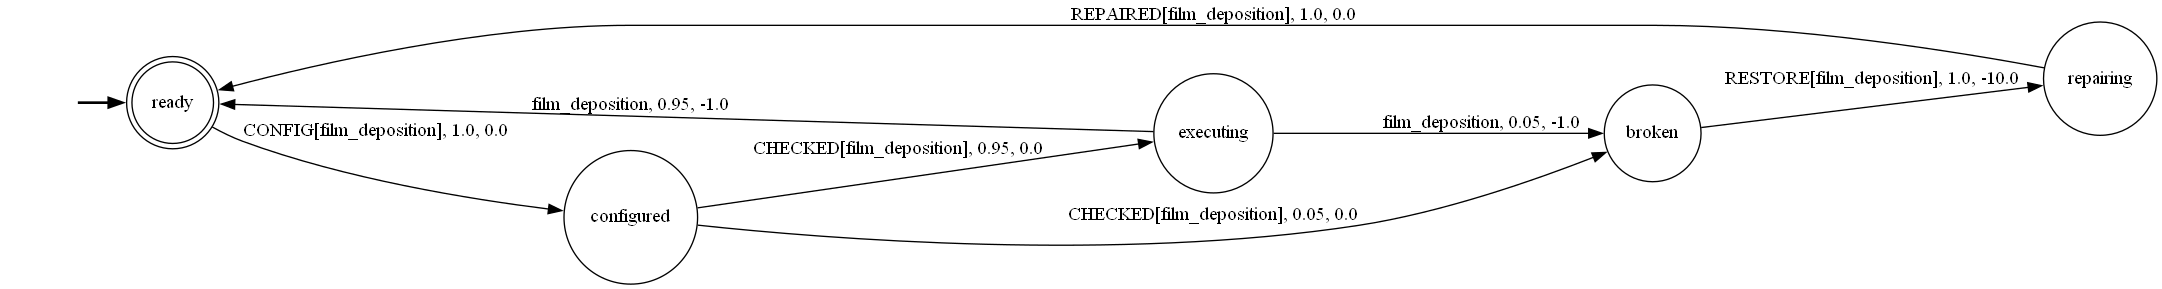

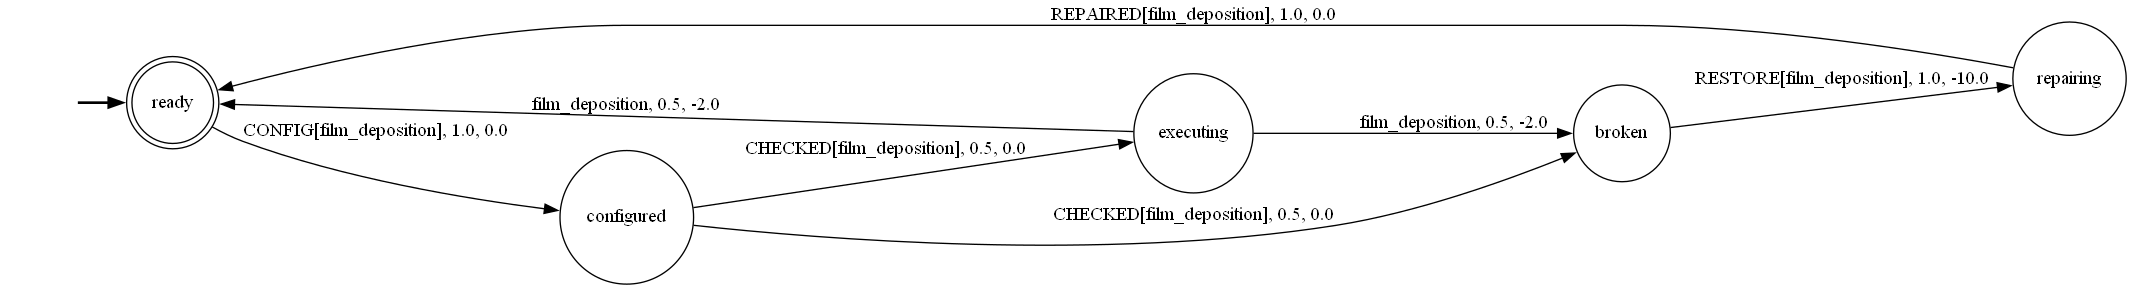

In [84]:
def film_deposition_service(name: str, broken_prob: float, unemployable_prob: float, broken_reward: float, action_reward: float) -> Service:
    """Build the film deposition device."""
    return build_complex_breakable_service(name, FILM_DEPOSITION, broken_prob=broken_prob, unemployable_prob=unemployable_prob, broken_reward=broken_reward, action_reward=action_reward)
service_film_deposition1=film_deposition_service(FILM_DEPOSITION1_SERVICE_NAME, DEFAULT_BROKEN_PROB, DEFAULT_UNEMPLOYABLE_PROB, DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD)
service_film_deposition2=film_deposition_service(FILM_DEPOSITION2_SERVICE_NAME, BROKEN_PROB, HIGH_UNEMPLOYABLE_PROB, DEFAULT_BROKEN_REWARD, USA_REWARD)
render_service(service_film_deposition1)
render_service(service_film_deposition2)

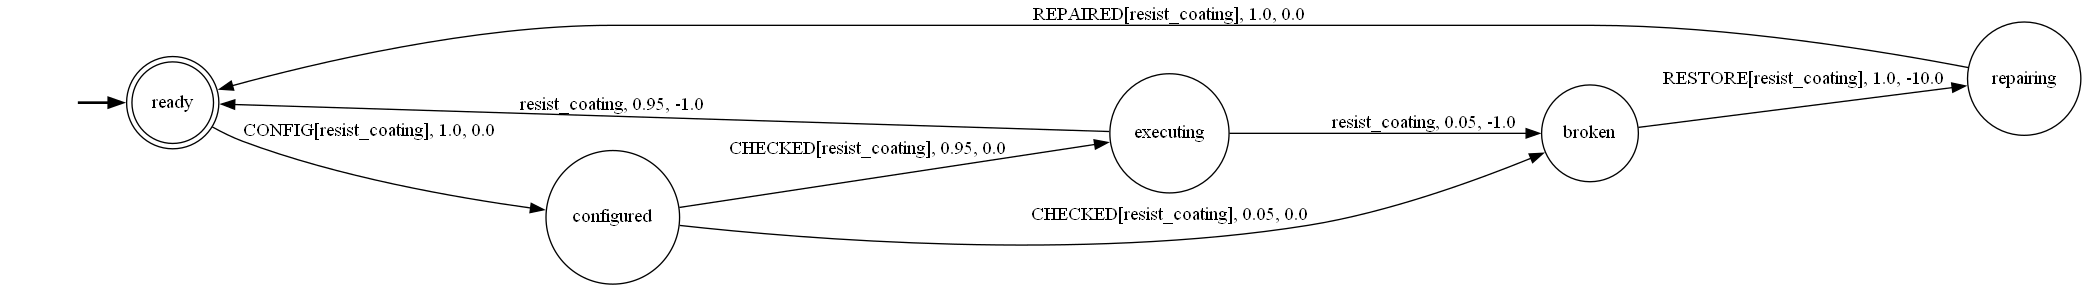

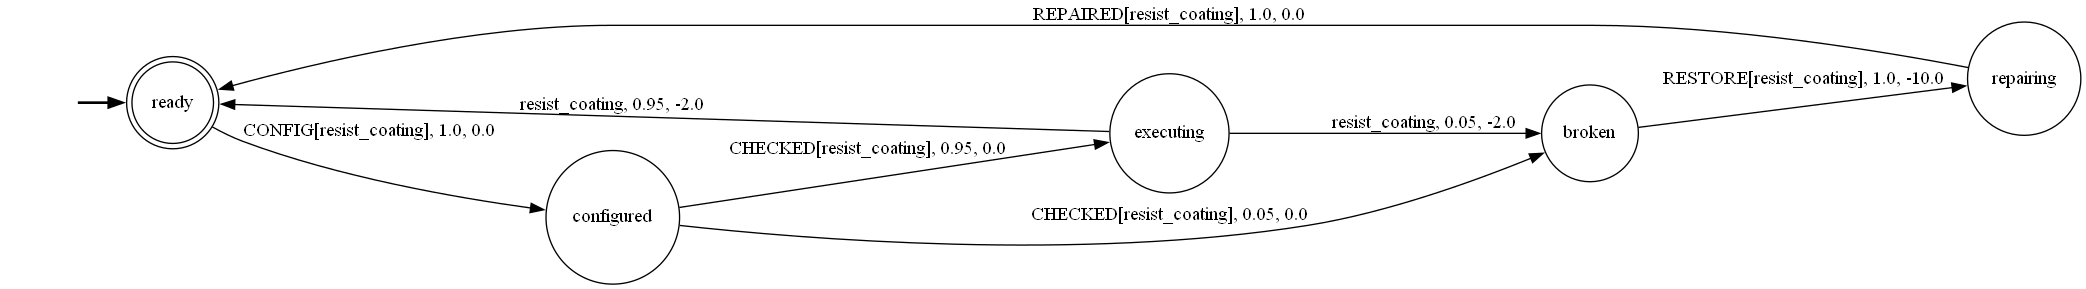

In [85]:
def resist_coating_service(name: str, broken_prob: float, unemployable_prob: float, broken_reward: float, action_reward: float) -> Service:
    """Build the resist coating device."""
    return build_complex_breakable_service(name, RESIST_COATING, broken_prob=broken_prob, unemployable_prob=unemployable_prob, broken_reward=broken_reward, action_reward=action_reward)
service_resist_coating1=resist_coating_service(RESIST_COATING1_SERVICE_NAME, DEFAULT_BROKEN_PROB, DEFAULT_UNEMPLOYABLE_PROB, DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD)
service_resist_coating2=resist_coating_service(RESIST_COATING2_SERVICE_NAME, DEFAULT_BROKEN_PROB, DEFAULT_UNEMPLOYABLE_PROB, DEFAULT_BROKEN_REWARD, USA_REWARD)
render_service(service_resist_coating1)
render_service(service_resist_coating2)

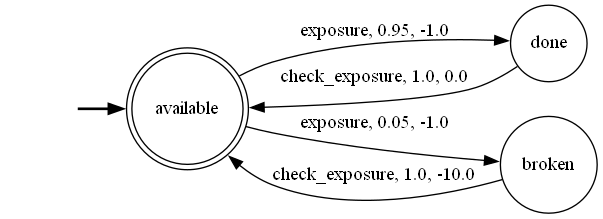

In [86]:
def exposure_service(name: str = EXPOSURE_SERVICE_NAME, broken_prob: float = DEFAULT_BROKEN_PROB, broken_reward: float = DEFAULT_BROKEN_REWARD, action_reward: float = DEFAULT_USA_REWARD) -> Service:
    """Build the exposure device."""
    return build_generic_breakable_service(name, EXPOSURE, broken_prob=broken_prob, broken_reward=broken_reward, action_reward=action_reward)
service_exposure=exposure_service()
render_service(service_exposure)

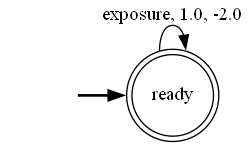

In [87]:
def exposure_human_service(name: str = EXPOSURE_HUMAN_SERVICE_NAME, action_reward: float = USA_REWARD) -> Service:
    """Build the human exposure device."""
    return build_generic_service_one_state(
        name,
        {EXPOSURE},
        action_reward=action_reward
    )

service_exposure_human = exposure_human_service()
render_service(service_exposure_human)

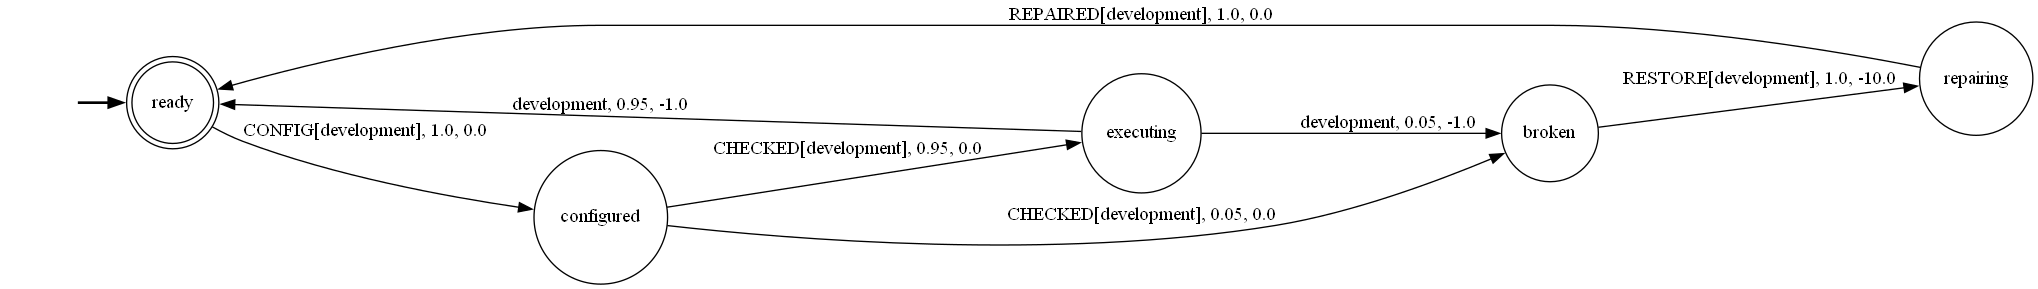

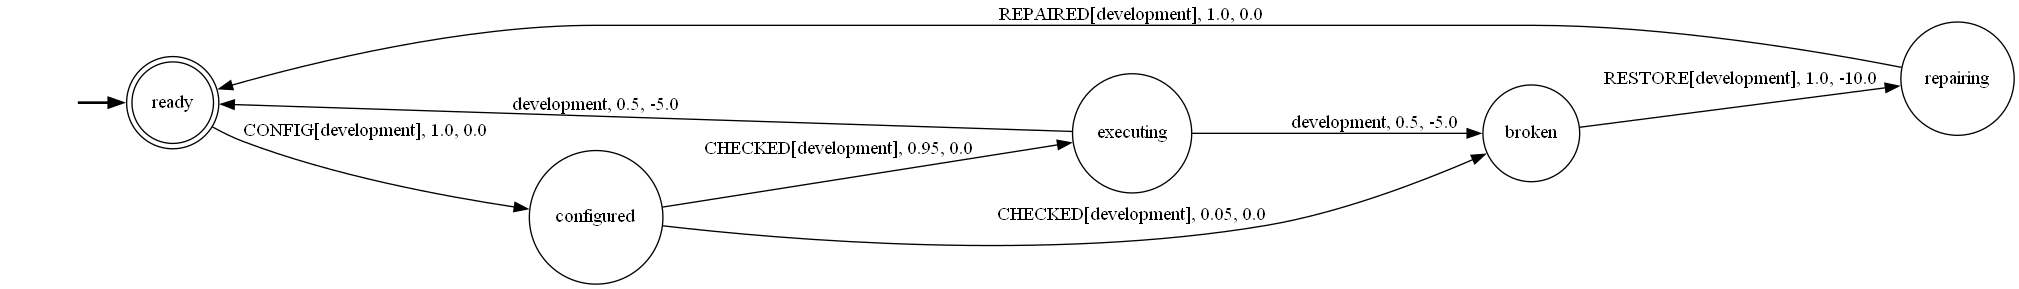

In [88]:
def development_service(name: str, broken_prob: float, unemployable_prob: float, broken_reward: float, action_reward: float) -> Service:
    """Build the development device."""
    return build_complex_breakable_service(name, DEVELOPMENT, broken_prob=broken_prob, unemployable_prob=unemployable_prob, broken_reward=broken_reward, action_reward=action_reward)
service_development1=development_service(DEVELOPMENT1_SERVICE_NAME, DEFAULT_BROKEN_PROB, DEFAULT_UNEMPLOYABLE_PROB,DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD)
service_development2=development_service(DEVELOPMENT2_SERVICE_NAME, BROKEN_PROB, DEFAULT_UNEMPLOYABLE_PROB,DEFAULT_BROKEN_REWARD, HIGH_USA_REWARD)
render_service(service_development1)
render_service(service_development2)

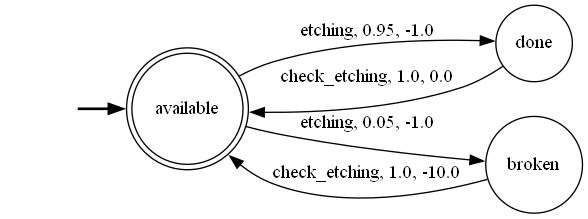

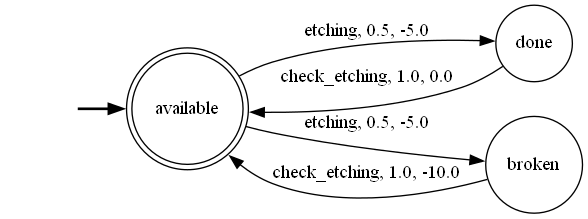

In [89]:
def etching_service(name: str, broken_prob: float, broken_reward: float, action_reward: float) -> Service:
    """Build the etching device."""
    return build_generic_breakable_service(name, ETCHING, broken_prob=broken_prob, broken_reward=broken_reward, action_reward=action_reward)
service_etching1=etching_service(ETCHING1_SERVICE_NAME, DEFAULT_BROKEN_PROB, DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD)
service_etching2=etching_service(ETCHING2_SERVICE_NAME, BROKEN_PROB, DEFAULT_BROKEN_REWARD, HIGH_USA_REWARD)
render_service(service_etching1)
render_service(service_etching2)

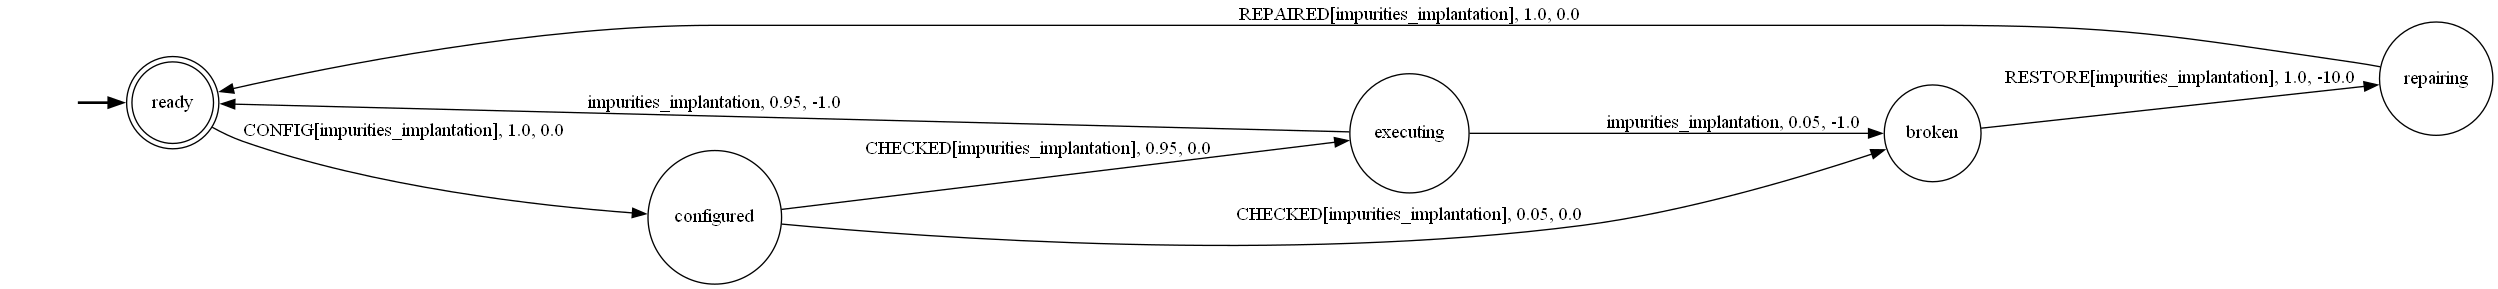

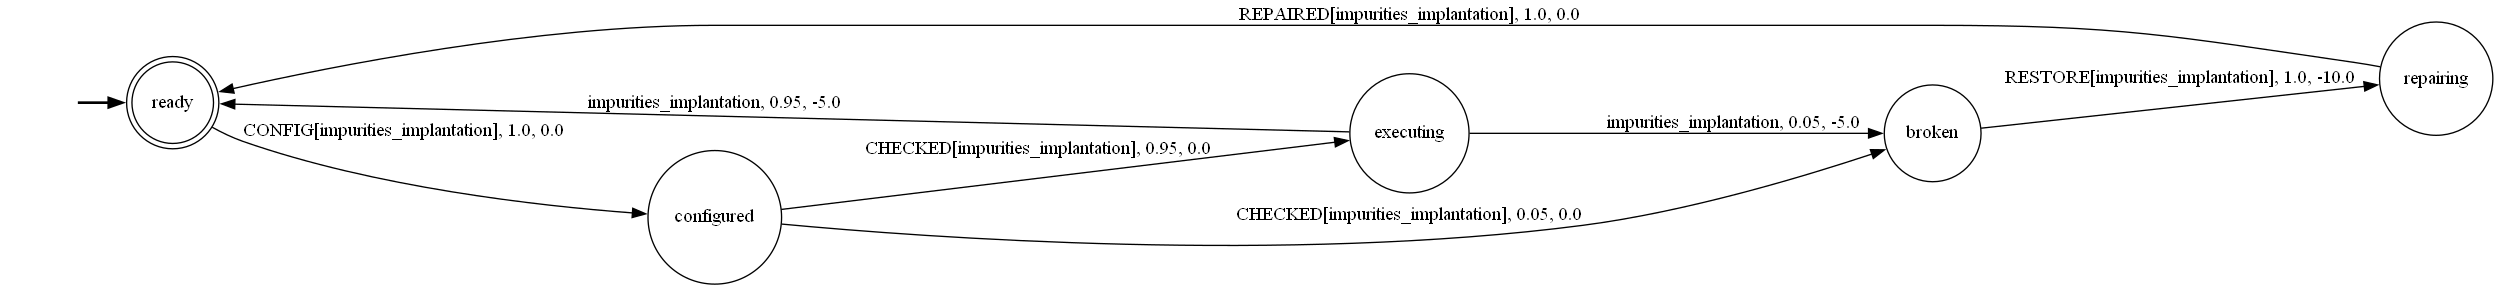

In [90]:
def impurities_implantation_service(name: str, broken_prob: float, unemployable_prob: float, broken_reward: float, action_reward: float) -> Service:
    """Build the impurities implantation device."""
    return build_complex_breakable_service(name, IMPURITIES_IMPLANTATION, broken_prob=broken_prob, unemployable_prob=unemployable_prob, broken_reward=broken_reward, action_reward=action_reward)
service_impurities_implantation1=impurities_implantation_service(IMPURITIES_IMPLANTATION1_SERVICE_NAME, DEFAULT_BROKEN_PROB, DEFAULT_UNEMPLOYABLE_PROB, DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD)
service_impurities_implantation2=impurities_implantation_service(IMPURITIES_IMPLANTATION2_SERVICE_NAME, DEFAULT_BROKEN_PROB, DEFAULT_UNEMPLOYABLE_PROB, DEFAULT_BROKEN_REWARD, HIGH_USA_REWARD)
render_service(service_impurities_implantation1)
render_service(service_impurities_implantation2)

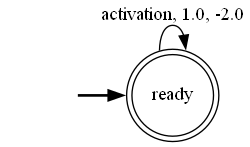

In [91]:
def activation_human_service(name: str = ACTIVATION_HUMAN_SERVICE_NAME, action_reward: float = USA_REWARD) -> Service:
    """Build the human activation device."""
    return build_generic_service_one_state(
        name,
        {ACTIVATION},
        action_reward=action_reward
    )

service_activation_human = activation_human_service()
render_service(service_activation_human)

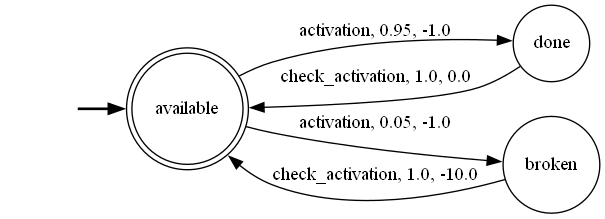

In [92]:
def activation_service(name: str = ACTIVATION_SERVICE_NAME, broken_prob: float = DEFAULT_BROKEN_PROB,  broken_reward: float = DEFAULT_BROKEN_REWARD, action_reward: float = DEFAULT_USA_REWARD) -> Service:
    """Build the activation device."""
    return build_generic_breakable_service(name, ACTIVATION, broken_prob=broken_prob, broken_reward=broken_reward, action_reward=action_reward)
service_activation=activation_service()
render_service(service_activation)

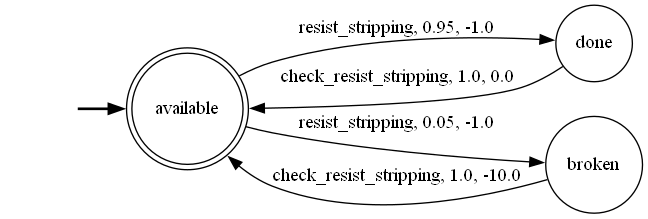

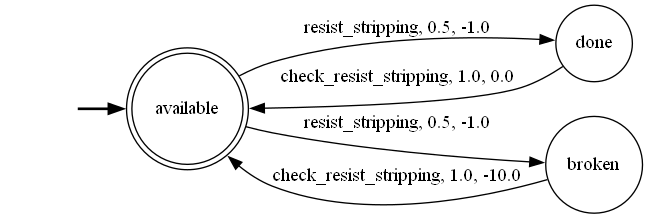

In [93]:
def resist_stripping_service(name: str, broken_prob: float, broken_reward: float, action_reward: float) -> Service:
    """Build the resist stripping device."""
    return build_generic_breakable_service(name, RESIST_STRIPPING, broken_prob=broken_prob, broken_reward=broken_reward, action_reward=action_reward)
service_resist_stripping1=resist_stripping_service(RESIST_STRIPPING1_SERVICE_NAME, DEFAULT_BROKEN_PROB, DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD)
service_resist_stripping2=resist_stripping_service(RESIST_STRIPPING2_SERVICE_NAME, BROKEN_PROB, DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD)
render_service(service_resist_stripping1)
render_service(service_resist_stripping2)

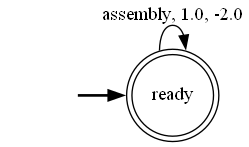

In [94]:
def assembly_human_service(name: str = ASSEMBLY_HUMAN_SERVICE_NAME, action_reward: float = USA_REWARD) -> Service:
    """Build the human assembly device."""
    return build_generic_service_one_state(
        name,
        {ASSEMBLY},
        action_reward=action_reward
    )

service_assembly_human = assembly_human_service()
render_service(service_assembly_human)

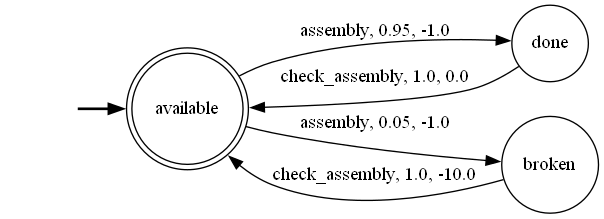

In [95]:
def assembly_service(name: str = ASSEMBLY_SERVICE_NAME, broken_prob: float = DEFAULT_BROKEN_PROB, broken_reward: float = DEFAULT_BROKEN_REWARD, action_reward: float = DEFAULT_USA_REWARD) -> Service:
    """Build the assembly device."""
    return build_generic_breakable_service(name, ASSEMBLY, broken_prob=broken_prob, broken_reward=broken_reward, action_reward=action_reward)
service_assembly=assembly_service()
render_service(service_assembly)

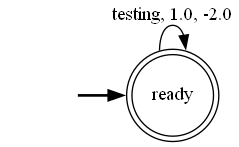

In [96]:
def testing_human_service(name: str = TESTING_HUMAN_SERVICE_NAME, action_reward: float = USA_REWARD) -> Service:
    """Build the human testing device."""
    return build_generic_service_one_state(
        name,
        {TESTING},
        action_reward=action_reward
    )

service_testing_human = testing_human_service()
render_service(service_testing_human)

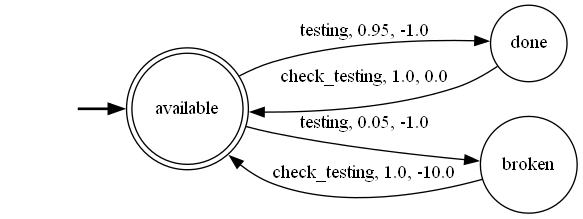

In [97]:
def testing_service(name: str = TESTING_SERVICE_NAME, broken_prob: float = DEFAULT_BROKEN_PROB, broken_reward: float = DEFAULT_BROKEN_REWARD, action_reward: float = DEFAULT_USA_REWARD) -> Service:
    """Build the testing device."""
    return build_generic_breakable_service(name, TESTING, broken_prob=broken_prob, broken_reward=broken_reward, action_reward=action_reward)
service_testing=testing_service()
render_service(service_testing)

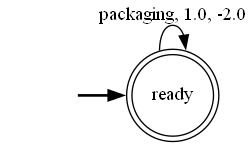

In [98]:
def packaging_human_service(name: str = PACKAGING_HUMAN_SERVICE_NAME, action_reward: float = USA_REWARD) -> Service:
    """Build the human packaging device."""
    return build_generic_service_one_state(
        name,
        {PACKAGING},
        action_reward=action_reward
    )

service_packaging_human = packaging_human_service()
render_service(service_packaging_human)

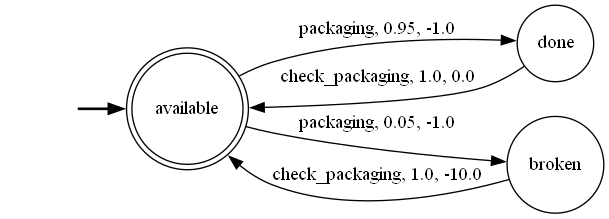

In [99]:
def packaging_service(name: str = PACKAGING_SERVICE_NAME, broken_prob: float = DEFAULT_BROKEN_PROB, broken_reward: float = DEFAULT_BROKEN_REWARD, action_reward: float = DEFAULT_USA_REWARD) -> Service:
    """Build the packaging device."""
    return build_generic_breakable_service(name, PACKAGING, broken_prob=broken_prob, broken_reward=broken_reward, action_reward=action_reward)
service_packaging=packaging_service()
render_service(service_packaging)

# Target Specification
The target specification is a deterministic sequence of actions, i.e. the sequence of steps to follow in order to product the chip.

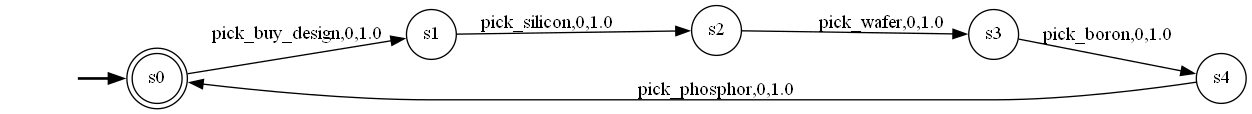

In [100]:
def target_service():
    """Build the target service."""
    transition_function = {
        "s0": {
            "pick_buy_design": ("s1", 1.0, 0),
        },
        "s1": {"pick_silicon": ("s2", 1.0, 0),
        },
        "s2": {"pick_wafer": ("s3", 1.0, 0),},
        "s3": {"pick_boron": ("s4", 1.0, 0), },
        "s4": {"pick_phosphor": ("s5", 1.0, 0), },
        "s5": {"cleaning": ("s6", 1.0, 0), },
        "s6": {"CONFIG[film_deposition]": ("s7", 1.0, 0), },
        "s7": {"CHECKED[film_deposition]": ("s8", 1.0, 0), },
        "s8": {"film_deposition": ("s9", 1.0, 0), },
        "s9": {"CONFIG[resist_coating]": ("s10", 1.0, 0), },
        "s10": {"CHECKED[resist_coating]": ("s11", 1.0, 0), },
        "s11": {"resist_coating": ("s12", 1.0, 0), },
        "s12": {"exposure": ("s13", 1.0, 0), },
        "s13": {"check_exposure": ("s14", 1.0, 0), },
        "s14": {"CONFIG[development]": ("s15", 1.0, 0), },
        "s15": {"CHECKED[development]": ("s16", 1.0, 0), },
        "s16": {"development": ("s17", 1.0, 0), },
        "s17": {"etching": ("s18", 1.0, 0), },
        "s18": {"check_etching": ("s19", 1.0, 0), },
        "s19": {"CONFIG[impurities_implantation]": ("s20", 1.0, 0), },
        "s20": {"CHECKED[impurities_implantation]": ("s21", 1.0, 0), },
        "s21": {"impurities_implantation": ("s22", 1.0, 0), },
        "s22": {"activation": ("s23", 1.0, 0), },
        "s23": {"resist_stripping": ("s24", 1.0, 0), },
        "s24": {"check_resist_stripping": ("s25", 1.0, 0), },
        "s25": {"assembly": ("s26", 1.0, 0), },
        "s26": {"testing": ("s27", 1.0, 0), },
        "s27": {"packaging": ("s0", 1.0, 0), }
    }

    initial_state = "s0"
    final_states = {"s0"}

    return build_target_from_transitions(
        transition_function, initial_state, final_states
    )

target = target_service()
render_target(target)


## Composition MDP
In the following, we solve a simplified composition problem considering the procurement process by using only the first part of one-state services.

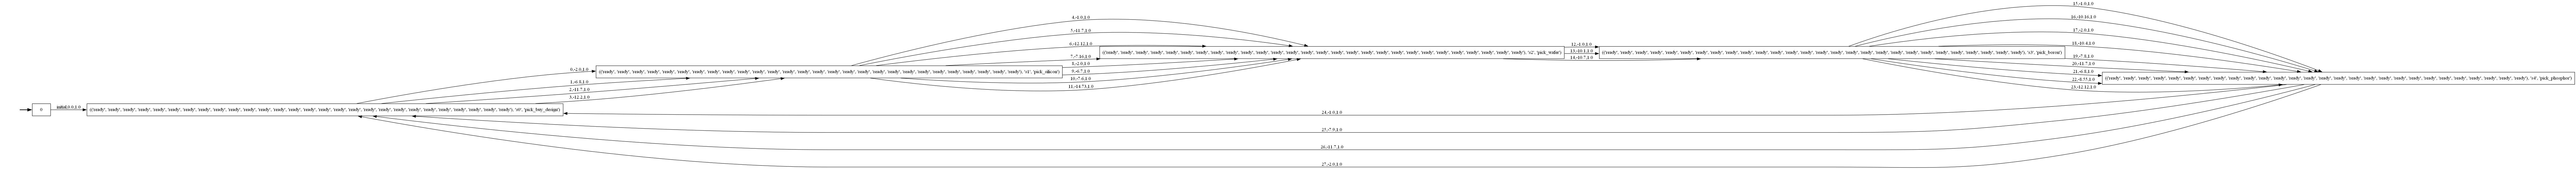

Number of states:  6


In [101]:
all_services = [
    # 0
    service_design_usa,
    # 1
    service_design_uk,
    # 2
    service_design_china,
    # 3
    service_design_taiwan,
    # 4
    service_silicon_warehouse,
    # 5
    service_silicon_china,
    # 6
    service_silicon_russia,
    # 7
    service_silicon_norway,
    # 8
    service_silicon_usa,
    # 9
    service_silicon_brazil,
    # 10
    service_silicon_france,
    # 11
    service_silicon_malaysia,
    # 12
    service_wafer_warehouse,
    # 13
    service_wafer_japan,
    # 14
    service_wafer_south_korea,
    # 15
    service_boron_warehouse,
    # 16
    service_boron_turkey,
    # 17
    service_boron_usa,
    # 18
    service_boron_kazakhstan,
    # 19
    service_boron_chile,
    # 20
    service_boron_china,
    # 21
    service_boron_bolivia,
    # 22
    service_boron_argentina,
    # 23
    service_boron_russia,
    # 24
    service_phosphor_warehouse,
    # 25
    service_phosphor_morocco,
    # 26
    service_phosphor_china,
    # 27
    service_phosphor_usa,
    # 28
    service_cleaning,
    # 29
    service_cleaning_human,
    # 30
    service_film_deposition1,
    # 31
    service_film_deposition2,
    # 32
    service_resist_coating1,
    # 33
    service_resist_coating2,
    # 34
    service_exposure,
    # 35
    service_exposure_human,
    # 36
    service_development1,
    # 37
    service_development2,
    # 38
    service_etching1,
    # 39
    service_etching2,
    # 40
    service_impurities_implantation1,
    # 41
    service_impurities_implantation2
]
mdp = composition_mdp(target, *all_services, gamma=0.9)
render_composition_mdp(mdp)
print("Number of states: ", len(mdp.all_states))

## Optimal policy
Calculation of optimal policy:

In [102]:

opn = DPAnalytic(mdp, 1e-4)
opt_policy = opn.get_optimal_policy_vi()
value_function = opn.get_value_func_dict(opt_policy)
q_value_function = opn.get_act_value_func_dict(opt_policy)

# remove '0' state to sort output
opt_policy.policy_data.pop(0, None)
value_function.pop(0, None)
_ = q_value_function.pop(0, None)

In [103]:
print_policy_data(opt_policy)

Policy:
State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 's0', 'pick_buy_design'),	Action=0
State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 's1', 'pick_silicon'),	Action=4
State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 's2', 'pick_wafer'),	Action=12
State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'rea

## Value Function
Calculation of Value Function:

In [104]:
print_value_function(value_function)

Value function:
State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 's0', 'pick_buy_design'),	value=-12.4419428096994
State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 's1', 'pick_silicon'),	value=-11.602158677443779
State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 's2', 'pick_wafer'),	value=-11.780176308270864
State=(('ready', 'ready', 'ready', 'ready', 'ready', 'r

In [105]:
print_q_value_function(q_value_function)

Q-value function:
State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 's0', 'pick_buy_design'):
	Action=0,	Value=-12.441942809699402
	Action=1,	Value=-17.241942809699403
	Action=2,	Value=-22.1419428096994
	Action=3,	Value=-22.6419428096994

State=(('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 's1', 'pick_silicon'):
	Action=4,	Value=-11.602158677443779
	Action=5,	Value=-22.302158677443778
	Action=6,	Value=-22.72215867744378
	Action=7,	Value=-17.76215867744378
	Action=8,	Value=-12.602158677443779
	Action=9,	Value=-17.302158677443778
	Action=10,	Value=-18.202158677443776
	Action=

From the calculation of the optimal policy we observe that:
- the planner preferred using service `service_design_usa` (service `0`) because it was more convenient choose the service located in usa than the services of other countries;
- the planner preferred using service `service_silicon_warehouse` (service `4`) because it was more convenient pick the silicon from the warehouse instead of picking it from other countries;
- the planner preferred using service `service_wafer_warehouse` (service `12`) because it was more convenient pick the wafer from the warehouse instead of picking it from other countries;
- the planner preferred using service `service_boron_warehouse` (service `15`) because it was more convenient pick the boron from the warehouse instead of picking it from other countries;
- the planner preferred using service `service_phosphor_warehouse` (service `24`) because it was more convenient pick the phosphor from the warehouse instead of picking it from other countries.